In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from collections import Counter
import random
from utils import load_model, save_checkpoint
from pyfm import pylibfm
from fastFM import als
from sklearn.feature_extraction import DictVectorizer
import time

## PreProcess

In [3]:
food_data = pd.read_csv("data/food.csv")
rating_data = pd.read_csv("data/rating_train.csv")
user_data = pd.read_csv("data/user.csv")
food_data.replace('-', np.nan, inplace=True)
rating_data[['year', 'month', 'day']] = rating_data['date'].str.split('-', expand=True)
rating_data['date'] = rating_data['date'].str.replace('-','')
user_ids = user_data['userid'].sort_values(axis=0).reset_index(drop=True).values.tolist()
user_data.fillna(0, inplace=True)
user_data['age'] = user_data['age'].apply(lambda x: x//5)
user_data['age'] = user_data['age'].apply(lambda x: x/7)
user_data['mapped_userid'] = user_data['userid'].apply(lambda x: user_ids.index(x))

food_data.drop(['annotated_food_name'], axis=1, inplace=True)
for h in list(food_data):
    if h.endswith('cat'):
        food_data[h][food_data[h].notnull()] = 1
food_data.fillna(0, inplace=True)

/home/victai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [4]:
rating_data['mapped_userid'] = rating_data['userid'].apply(lambda x: user_ids.index(x))

In [5]:
#v = DictVectorizer()
user_features = user_data.drop(['userid', 'username', 'location', 'city', 'state', 'title', 'about_me', 'reasons', 'inspirations', 'friends_count'], axis=1).sort_values(by='mapped_userid').values
user_feature_list = ['age', 'gender', 'mapped_userid']
user_features[:,2] = user_features[:,2].astype(str)
user_features = [{k:v for k, v in zip(user_feature_list, u)} for u in user_features]
#print(v.fit_transform(user_features).shape)
#transformed_user_features = v.fit_transform(transformed_user_features).toarray()

#food_features = food_data.drop(list(food_data.filter(regex=".*_q")), axis=1)
#food_features = food_features.drop(list(food_data.filter(regex=".*cat")), axis = 1)
#food_features = food_features.drop(list(food_data.filter(regex=".*_unit")), axis=1)
#food_features = food_features.drop(['foodid'], axis=1)
food_features = food_data['foodid']
food_feature_list = list(food_features)
food_features = food_features.values.astype(str)
food_features = [{"foodid": f} for f in food_features]
#print(v.fit_transform(food_features).shape)
#food_features = [{k:v for k, v in zip(food_feature_list, f)} for f in food_features]
#transformed_food_features = v.fit_transform(transformed_food_features).toarray()

data_cnt = {}
for i in user_ids:
    data_cnt[i] = len(rating_data[rating_data['userid'] == i])

#plt.hist(list(data_cnt.values()), bins=20)
#list(data_cnt.values())

In [5]:
user_food_score = [{} for i in range(len(user_ids))]
for u, f in zip(rating_data['mapped_userid'], rating_data['foodid']):
    if user_food_score[u].get(f) != None:
        user_food_score[u][f] += 1
    else:
        user_food_score[u][f] = 1
    
for i in range(len(user_ids)):
    all_val = list(user_food_score[i].values())
    for k, v in user_food_score[i].items():
        user_food_score[i][k] = (v - min(all_val)) / (max(all_val) - min(all_val))

In [6]:
def create_dataset(rating_data, valid_p, use_features=False):
    user_id_train = []
    user_id_valid = []
    food_id_train = []
    food_id_valid = []
    food_feature_train = []
    food_feature_valid = []
    user_feature_train = []
    user_feature_valid = []
    Y_train = []
    Y_valid = []
    np.sort(user_ids)
    for u in range(len(user_ids)):
        current_user = rating_data[rating_data['mapped_userid'] == u]
        cnt = int(len(current_user) * (1 - valid_p))
        user_id_train.extend(current_user['mapped_userid'].iloc[:cnt])
        food_id_train.extend(current_user['foodid'].iloc[:cnt])
        user_id_valid.extend(current_user['mapped_userid'].iloc[cnt:])
        food_id_valid.extend(current_user['foodid'].iloc[cnt:])
        for i in range(len(current_user)):
            if i < cnt:
                Y_train.append(1)#user_food_score[u][current_user['foodid'].iloc[i]])
            else:
                Y_valid.append(1)#user_food_score[u][current_user['foodid'].iloc[i]])
  
    if use_features:
        for f in food_id_train:
            food_feature_train.append(food_features[f])
        for f in food_id_valid:
            food_feature_valid.append(food_features[f])
        for u in user_id_train:
            user_feature_train.append(user_features[u])
        for u in user_id_valid:
            user_feature_valid.append(user_features[u])
    
        return  np.array(user_id_train), np.array(user_id_valid), \
                np.array(food_id_train), np.array(food_id_valid), \
                np.array(food_feature_train), np.array(food_feature_valid), \
                np.array(user_feature_train), np.array(user_feature_valid), \
                np.array(Y_train), np.array(Y_valid)
    else:
        return  np.array(user_id_train), np.array(user_id_valid), \
                np.array(food_id_train), np.array(food_id_valid), \
                np.array(Y_train), np.array(Y_valid)

In [7]:
valid_percentage = 0.0
user_id_train, user_id_valid, food_id_train, food_id_valid, food_feature_train, food_feature_valid, user_feature_train, user_feature_valid, Y_train, Y_valid = create_dataset(rating_data, valid_percentage, True)
#user_id_train, user_id_valid, food_id_train, food_id_valid, Y_train, Y_valid = create_dataset(rating_data, valid_percentage, False)

#order = np.arange(len(user_id_train))
#random.seed(0)
#random.shuffle(order)

In [8]:
not_eaten = {}
eaten = {}
for u in range(len(user_ids)):
    t_start_idx = np.where(user_id_train == u)[0][0]
    t_end_idx = np.where(user_id_train == u)[0][-1]
    v_start_idx = np.where(user_id_valid == u)[0][0]
    v_end_idx = np.where(user_id_valid == u)[0][-1]
    #tmp = []
    #for i in range(v_start_idx, v_end_idx+1):
        #if (food_id_valid[i] not in food_id_train[t_start_idx: t_end_idx+1]) and (food_id_valid[i] not in tmp):
        #    tmp.append(food_id_valid[i])
    #print(u)
    #print(t_end_idx)
    not_eaten[u] = np.setdiff1d(food_id_valid[v_start_idx: v_end_idx+1], food_id_train[t_start_idx: t_end_idx+1])
    eaten[u] = set(food_id_train[t_start_idx: t_end_idx+1])

In [12]:
ALL = []
for u in range(len(user_ids)):
    U = [user_features[u] for i in range(len(food_data))]
    F = [food_features[f] for f in range(len(food_data))]
    test_data = [{**x, **y} for x, y in list(zip(U, F))]
    ALL.extend(test_data)

In [13]:
v = DictVectorizer()
print(list(zip(user_feature_train, food_feature_train))[0])
train_data = [{**x, **y} for x, y in list(zip(user_feature_train, food_feature_train))]
train_data.extend(ALL)
train_data = v.fit_transform(train_data)
train_data = train_data[:-len(ALL)]

#valid_data = [{**x, **y} for x, y in list(zip(user_feature_valid, food_feature_valid))]
#valid_data.extend(ALL)
#valid_data = v.fit_transform(valid_data)
#valid_data = valid_data[:-len(ALL)]

({'gender': 'Female', 'mapped_userid': '0', 'age': 1.2857142857142858}, {'foodid': '0'})


#fm = pylibfm.FM(num_factors=10, num_iter=100, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(train_data, Y_train)
res = fm.predict(train_data)

In [16]:
def AveragePrecision(user_not_eaten, prediction, cnt):
    if len(user_not_eaten) == 0: return 0
    score = 0
    hit = 0
    for i, p in enumerate(prediction):
        if p in user_not_eaten:
            hit += 1
            score += hit / (i+1)
    score /= len(user_not_eaten)
    return score

In [21]:
eaten_mat = np.zeros((len(user_ids), len(rating_data.foodid.drop_duplicates())))
for i, j in zip(user_id_train, food_id_train):
    eaten_mat[i][j] = 1

iter 1; time: 54.45
iter 2; time: 57.88
iter 3; time: 57.09
iter 4; time: 56.19
iter 5; time: 55.62
iter 6; time: 73.37
iter 7; time: 80.64
iter 8; time: 79.05
iter 9; time: 71.82
iter 10; time: 61.75
iter 11; time: 55.23
iter 12; time: 56.01
iter 13; time: 54.87
iter 14; time: 57.36
iter 15; time: 55.77
iter 16; time: 75.78
iter 17; time: 72.80
iter 18; time: 71.17
iter 19; time: 64.04
iter 20; time: 82.67


ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

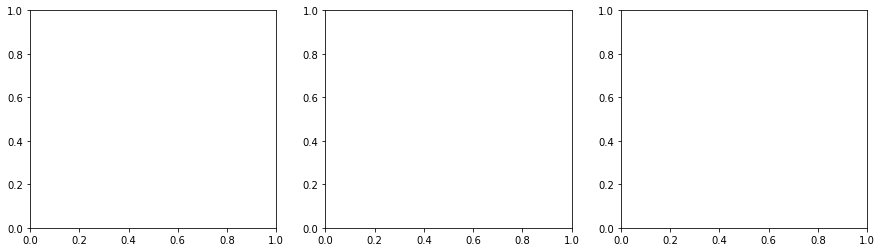

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
n_iter = 20
step_size = 1

fm = als.FMRegression(n_iter=0, l2_reg_w=0.0, l2_reg_V=0.0, rank=20)
# Allocates and initalizes the model parameter.
fm.fit(train_data, Y_train)

rmse_train = []
rmse_valid = []
r2_score_train = []
r2_score_valid = []
ap_valid = []
max_food = rating_data.foodid.max()+1
for it in range(1, n_iter+1):
    start_time = time.time()
    fm.fit(train_data, Y_train, n_more_iter=step_size)
   
    all_test = v.fit_transform(ALL)
    all_res = fm.predict(all_test)
    all_score = []
    if it == n_iter:
        all_ans = []
        for u in range(len(user_ids)):
            ans = []
            res = all_res[u*max_food: (u+1)*max_food]

            res = res.flatten()
            ordered_res = np.argsort(-res)
            filtered_res = [i for i in ordered_res if eaten_mat[u][i] == 0]
            #print(ans)
            #print(not_eaten[u])
            #print("===============================")
            #all_score.append(AveragePrecision(not_eaten[u], ans, 20))
            all_ans.append(filtered_res[:20])

    #ap_valid.append(np.array(all_score).mean())
    
    #rmse_train.append(np.sqrt(mean_squared_error(fm.predict(train_data), Y_train)))
    #rmse_valid.append(np.sqrt(mean_squared_error(fm.predict(valid_data), Y_valid)))

    #r2_score_train.append(r2_score(fm.predict(train_data), Y_train))
    #r2_score_valid.append(r2_score(fm.predict(valid_data), Y_valid))
    print("iter {0}; time: {1:.2f}".format(it, time.time()-start_time))


from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

x = np.arange(1, n_iter+1) * step_size
with plt.style.context('fivethirtyeight'):
    axes[0].plot(x, rmse_train, label='RMSE-train', color='r', ls="--")
    axes[0].plot(x, rmse_valid, label='RMSE-valid', color='r')
    axes[1].plot(x, r2_score_train, label='R^2-train', color='b', ls="--")
    axes[1].plot(x, r2_score_valid, label='R^2-valid', color='b')
    axes[2].plot(x, ap_valid, label='ap-valid', color='g')
axes[0].set_ylabel('RMSE', color='r')
axes[1].set_ylabel('R^2', color='b')
axes[2].set_ylabel('ap', color='g')
axes[0].legend()
axes[1].legend()
axes[2].legend()

In [29]:
np.array(all_ans).shape

(2608, 20)

## Inference

all_ans = []
all_score = []
all_test = []
all_test = v.fit_transform(ALL)
all_res = fm.predict(all_test)
for i, u in enumerate((user_ids)):
    ans = []
    res = all_res[i*len(user_ids): (i+1)*len(user_ids)]
    
    res = res.flatten()
    D = {k: v for (k, v) in zip(np.arange(len(food_data), dtype=int), res)}
    sorted_D = sorted(D.items(), key=lambda d: d[1], reverse=True)
    for x in sorted_D:
        if len(ans) >= 20: break
        if x[0] in user_food_score[u].keys():
            continue
        ans.append(x[0])
    all_score.append(AveragePrecision(not_eaten[u], ans, 20))
    all_ans.append(ans) 

In [ ]:
np.array(all_score).max()

## Generate Output

In [30]:
with open("pred.csv", 'w') as f:
    f.write("userid,foodid\n")
    for i in range(len(user_ids)):
        f.write("{},".format(user_ids[i]))
        for j in all_ans[i]:
            f.write("{} ".format(j))
        f.write('\n')